## Sampler test

Basic notebook to run a very small test chain using the sampler

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
from chainconsumer import ChainConsumer
# our own modules
import gp_emulator
import likelihood
import emcee_sampler
import data_MPGADGET
import z_emulator
import p1d_arxiv
import time

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label=10
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

will drop sim number 10 from emulator


In [3]:
# specify simulation suite and P1D mesurements
basedir="/p1d_emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4.0
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max)

read cosmology from GenIC /Users/font/Projects/LyaCosmoParams//p1d_emulator/sim_suites/Australia20/sim_pair_10/sim_plus/paramfile.genic
H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 1.6215E-09, n_s = 9.7257E-01, alpha_s = 0.0000E+00


In [4]:
# Set up emulator training set
z_max=4
arxiv=p1d_arxiv.ArxivP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
## Build emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=False,
                                emu_type="k_bin",passArxiv=arxiv,
                                kmax_Mpc=kmax_Mpc)
emu.load_default()

 /Library/Python/3.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


In [6]:
## Set up likelihood object
free_param_names=["Delta2_star","n_star","ln_tau_0"]
free_param_limits=[[0.24, 0.47], [-2.352, -2.25], [-0.2, 0.2]]
prior=None ## None for uniform prior, otherwise this value sets the width of the Gaussian within the unit prior volume
like=likelihood.Likelihood(data=data,emulator=emu,
                            free_param_names=free_param_names,
                            free_param_limits=free_param_limits,
                            prior_Gauss_rms=prior)

In [7]:
## Set up sampler
sampler = emcee_sampler.EmceeSampler(like=like,
                        free_param_names=free_param_names,verbose=False,
                        nwalkers=10,
                        save_chain=False,
                        progress=True)

In [8]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

Delta2_star 0.28381746693304927 0.24 0.47
n_star -2.291946940174626 -2.352 -2.25
ln_tau_0 0.0 -0.2 0.2


In [9]:
n_burn_in=100
n_steps=300 ## Max number of steps to run

start = time.time()
sampler.run_sampler(n_burn_in,n_steps,parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

Sampling took 136.5 seconds


 /Library/Python/3.7/site-packages/ipykernel_launcher.py:8: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


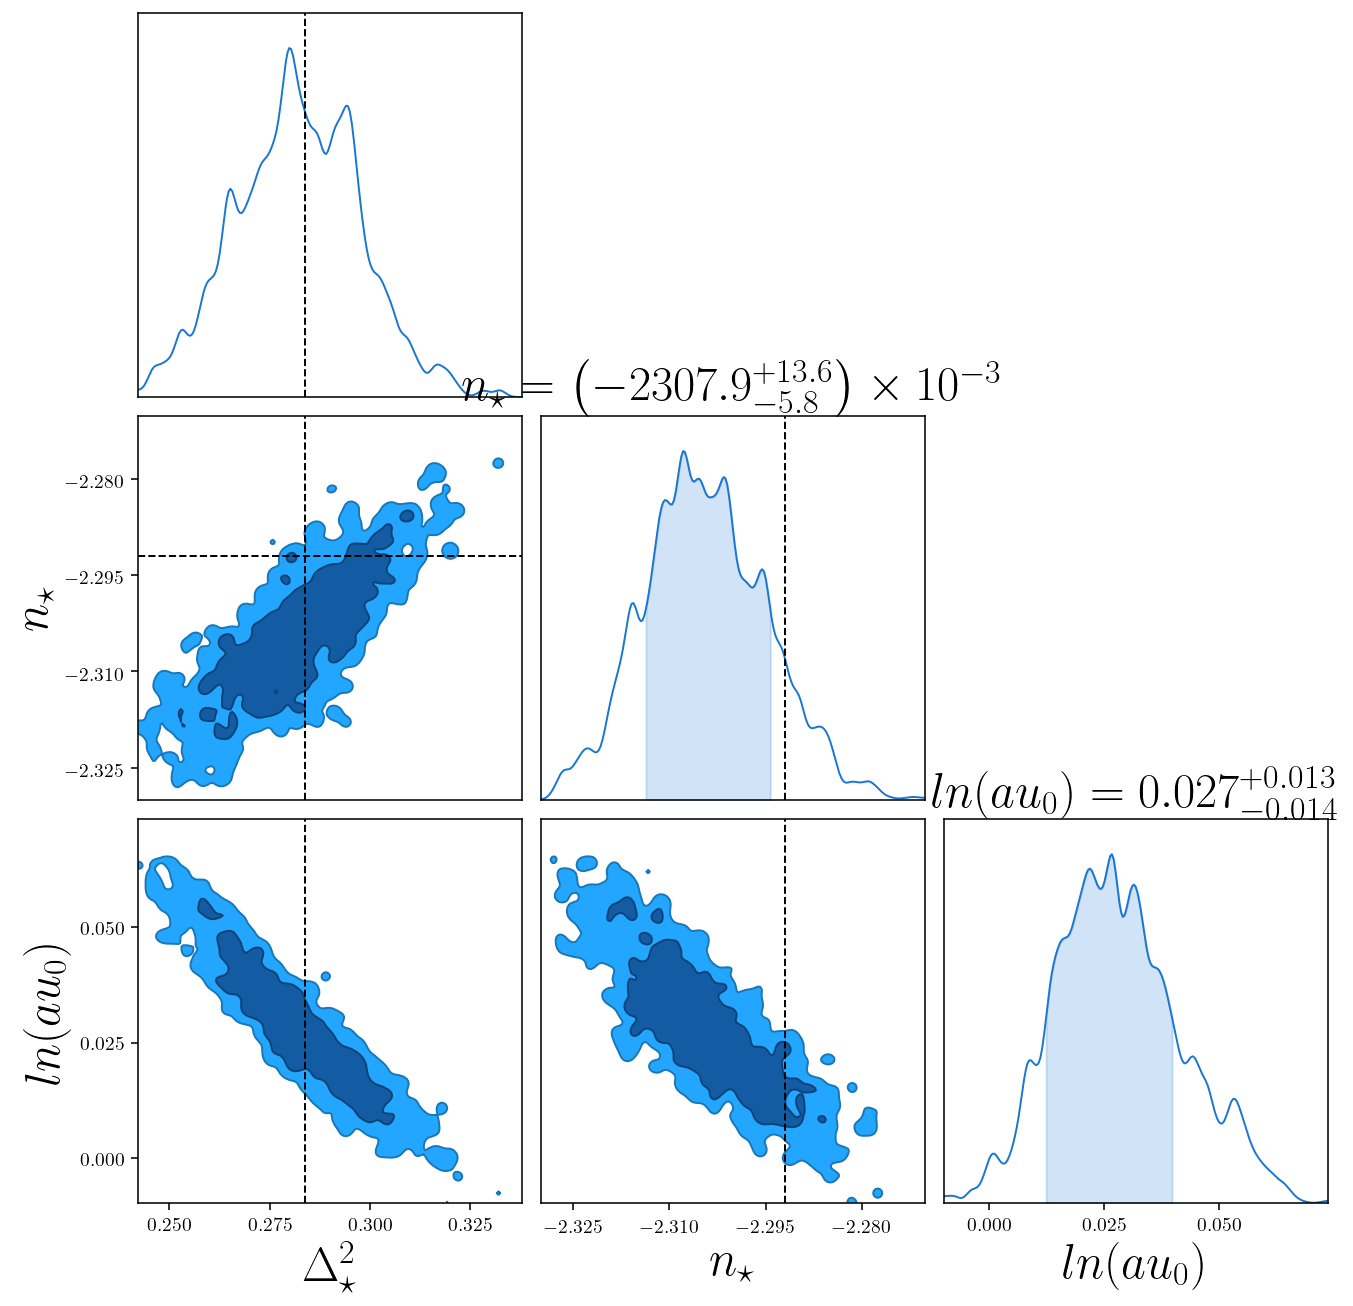

In [10]:
## Plot chains
chain_test,lnprob_test=sampler.get_chain(cube=False)
c=ChainConsumer()
c.add_chain(chain_test,parameters=sampler.paramstrings)
truth={sampler.paramstrings[0]:sampler.truth[0],sampler.paramstrings[1]:sampler.truth[1]}
c.configure(diagonal_tick_labels=False, tick_font_size=10, label_font_size=25, max_ticks=4)
fig = c.plotter.plot(figsize=(10,10),truth=truth)
fig.show()

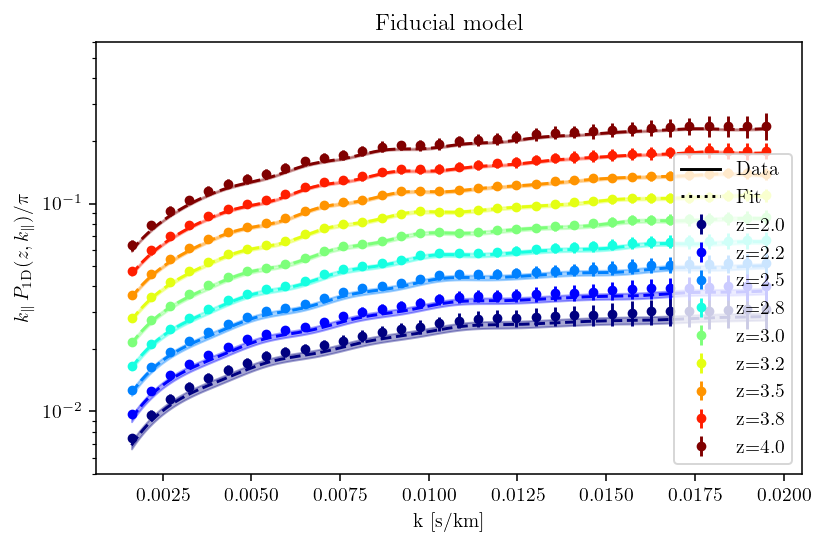

In [11]:
## Plot fiducial P1D
sampler.plot_prediction()

Mean values: [0.1831716362284781, 0.4674826548477739, 0.5708443724083226]


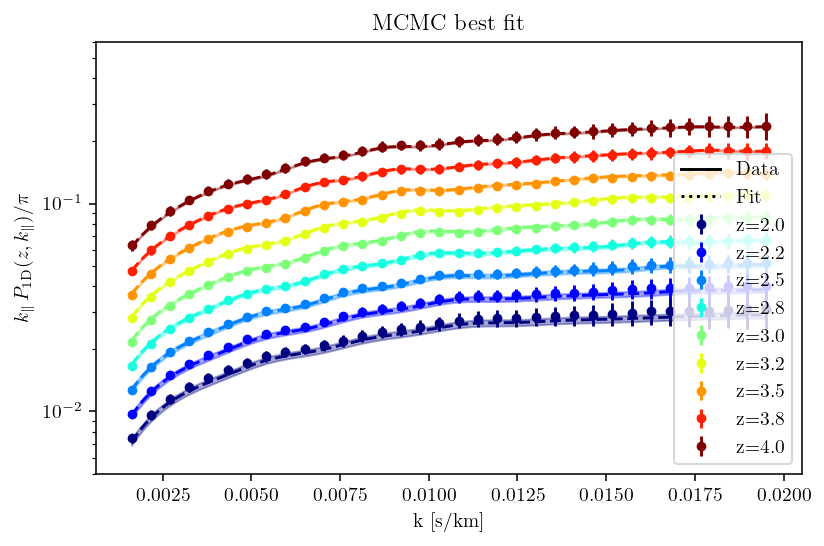

In [12]:
## Plot MCMC best-fit P1D
sampler.plot_best_fit()